# Weight Initialization
In this lesson, you'll learn how to find good initial weights for a neural network. Having good initial weights can place the neural network close to the optimal solution. This allows the neural network to come to the best solution quicker. 


### Dataset
To see how different weights perform, we'll test on the same dataset and neural network. Let's go over the dataset and neural network.

We'll be using the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) to demonstrate the different initial weights. As a reminder, the MNIST dataset contains images of handwritten numbers, 0-9, with normalized input (0.0 - 1.0).  Run the cell below to download and load the MNIST dataset.

In [20]:
# Import necessary packages
from __future__ import print_function
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [21]:
# Import MNIST data so we have something for our experiments
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True)

In [24]:
def hist_dist(title, values, hist_range=(-4, 4)):
    plt.title(title)
    plt.hist(values, np.linspace(*hist_range, num=len(values)/2))
    plt.show()

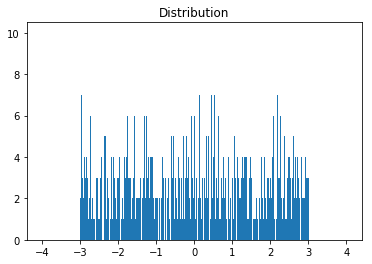

In [25]:
r = torch.Tensor(1000).uniform_(-3, 3)

hist_dist('Distribution', r)

## Pytorch Weight Initialization

PyTorch layers are initialized by default in their respective `reset_parameters()` method. For example:

- `nn.Linear`
    - `weight` and `bias`: uniform distribution [-limit, +limit] where `limit` is `1. / sqrt(fan_in)` and `fan_in` is the number of input units in the weight tensor.
- `nn.Conv2D`
    - `weight` and `bias`: uniform distribution [-limit, +limit] where `limit` is `1. / sqrt(fan_in)` and `fan_in` is the number of input units in the weight tensor.

With this implementation, the variance of the layer outputs is equal to `Var(W) = 1 / 3 * sqrt(fan_in)` which isn't the best initialization strategy out there.

Note that PyTorch provides convenience functions for some of the initializations. The input and output shapes are computed using the method `_calculate_fan_in_and_fan_out()` and a `gain()` method scales the standard deviation to suit a particular activation.

```python
# default xavier init
def init_weights(self):
        init.xavier_normal(self.fc1.weight, gain=nn.init.calculate_gain('relu')) 
```

#### Xavier Initialization

This initialization is general-purpose and meant to "work" pretty well for any activation in practice.

```python
# default xavier init
for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform(m.weight)
```

You can tailor this initialization to your specific activation by using the `nn.init.calculate_gain(act)` argument.

```python
# default xavier init
for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform(m.weight(), gain=nn.init.calculate_gain('relu'))
```

- [arXiv](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

#### He et. al Initialization

This is a similarly derived initialization tailored specifically for ReLU activations since they do not exhibit zero mean.

```python
# he initialization
for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal(m.weight, mode='fan_in')
```

For `mode=fan_in`, the variance of the distribution is ensured in the forward pass, while for `mode=fan_out`, it is ensured in the backwards pass.

- [arXiv](https://arxiv.org/abs/1502.01852)

#### SELU Initialization

Again, this initialization is specifically derived for the SELU activation function. The authors use the `fan_in` strategy. They mention that there is no significant difference between sampling from a Gaussian, a truncated Gaussian or a Uniform distribution.

```python
# selu init
for m in model.modules():
    if isinstance(m, nn.Conv2d):
        fan_in = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
        nn.init.normal(m.weight, 0, sqrt(1. / fan_in))
    elif isinstance(m, nn.Linear):
        fan_in = m.in_features
        nn.init.normal(m.weight, 0, sqrt(1. / fan_in))
```

- [arXiv](https://arxiv.org/abs/1706.02515)

#### Orthogonal Initialization

Orthogonality is a desirable quality in NN weights in part because it is norm preserving, i.e. it rotates the input matrix, but cannot change its norm (scale/shear). This property is valuable in deep or recurrent networks, where repeated matrix multiplication can result in signals vanishing or exploding.

```python
for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.orthogonal(m.weight)
```


In [7]:
def compare_init_weights(dataset, title, weight_init_list, plot_n_batches=100):
    """
    Plot loss and print stats of weights using an example neural network
    """
    colors = ['r', 'b', 'g', 'c', 'y', 'k']
    label_accs = []
    label_loss = []

    assert len(weight_init_list) <= len(colors), 'Too many inital weights to plot'

    for i, (weights, label) in enumerate(weight_init_list):
        loss, val_acc = _get_loss_acc(dataset, weights)

        plt.plot(loss[:plot_n_batches], colors[i], label=label)
        label_accs.append((label, val_acc))
        label_loss.append((label, loss[-1]))

    plt.title(title)
    plt.xlabel('Batches')
    plt.ylabel('Loss')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    print('After 858 Batches (2 Epochs):')
    print('Validation Accuracy')
    for label, val_acc in label_accs:
        print('  {:7.3f}% -- {}'.format(val_acc*100, label))
    print('Loss')
    for label, loss in label_loss:
        print('  {:7.3f}  -- {}'.format(loss, label))

For the neural network, we'll test on a 3 layer neural network with ReLU activations and an Adam optimizer.  The lessons you learn apply to other neural networks, including different activations and optimizers.

## Initialize Weights
Let's start looking at some initial weights.
### All Zeros or Ones
If you follow the principle of [Occam's razor](https://en.wikipedia.org/wiki/Occam's_razor), you might think setting all the weights to 0 or 1 would be the best solution.  This is not the case.

With every weight the same, all the neurons at each layer are producing the same output.  This makes it hard to decide which weights to adjust.

Let's compare the loss with all ones and all zero weights using `helper.compare_init_weights`.  This function will run two different initial weights on the neural network above for 2 epochs.  It will plot the loss for the first 100 batches and print out stats after the 2 epochs (~860 batches). We plot the first 100 batches to better judge which weights performed better at the start.

Run the cell below to see the difference between weights of all zeros against all ones.